In [70]:
import os
import sys
import numpy as np
import scipy as sp
import igraph as ig
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.io import loadmat
from collections import Counter
from scipy.special import comb

from mpl_settings_v3 import *

fig_dir = '../figs'

In [56]:
samples = 5000
n_agents = 10
data_dir = '../matrices'
matrices = readMatrices(data_dir, samples)

In [32]:
motives = [getMotives(A) for A in matrices]

In [37]:
tr_indices = list(map(triangleIndex, matrices))
walk_balances = list(map(walkBasedBalance, matrices))

In [57]:
D = (n_agents-1)*np.identity(n_agents)
algebraic_conflicts = [algebraicConflic(A, D) for A in matrices]

In [9]:
data_dir = '../output'
max_complexities = getComplexities(data_dir, samples, func=np.max)
mean_complexities = getComplexities(data_dir, samples, func=np.mean)

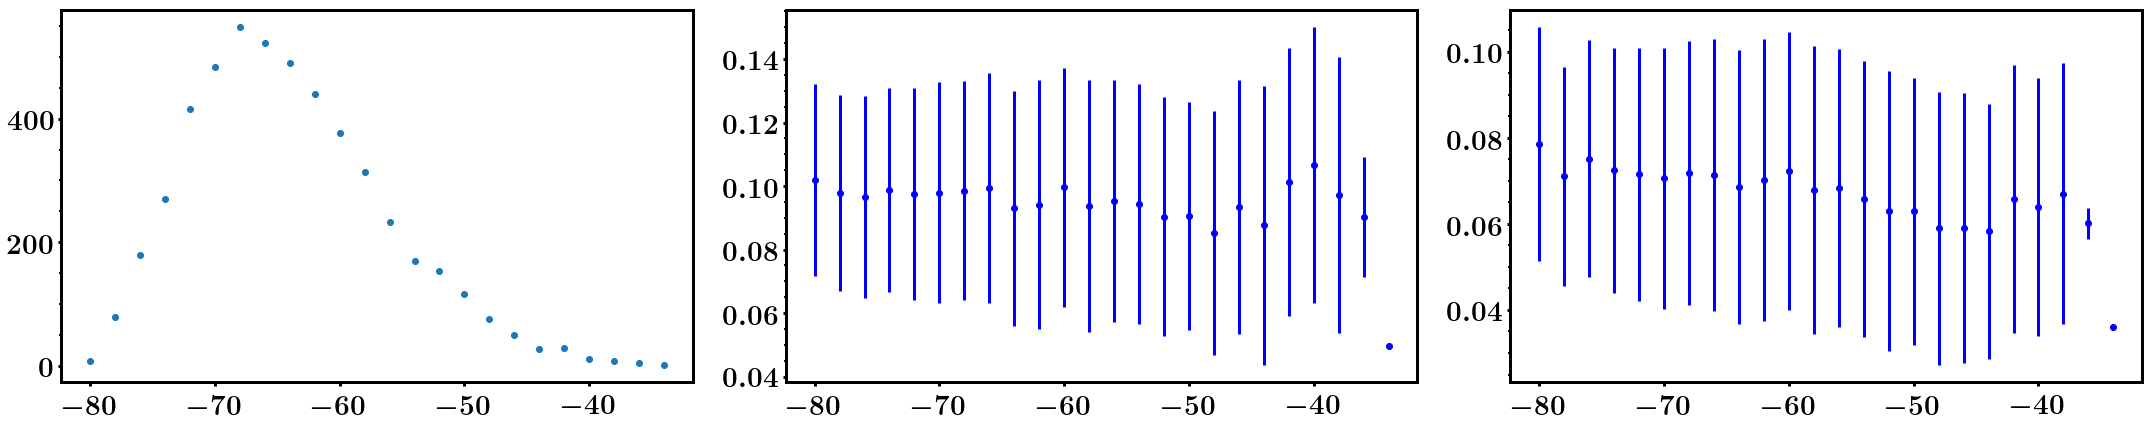

In [33]:
vec = [1, -1, -1, 1]    
irreg_indices = [irregularity_index(motif, vec) for motif in motives]

ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

indices = irreg_indices
c_max_dict = complexity_dict(indices, max_complexities)
c_mean_dict = complexity_dict(indices, mean_complexities)
values, count = np.unique(indices, return_counts=True)

ax = axes[0]
ax.plot(values, count, 'o')
for ax, c_dict in [[axes[1], c_max_dict], [axes[2], c_mean_dict]]:
    for k, v in sorted(c_dict.items(), key=lambda x: x[0]):
        ax.errorbar(k, np.mean(v), np.std(v), marker='o', color='blue')

plt.tight_layout()
plt.show()

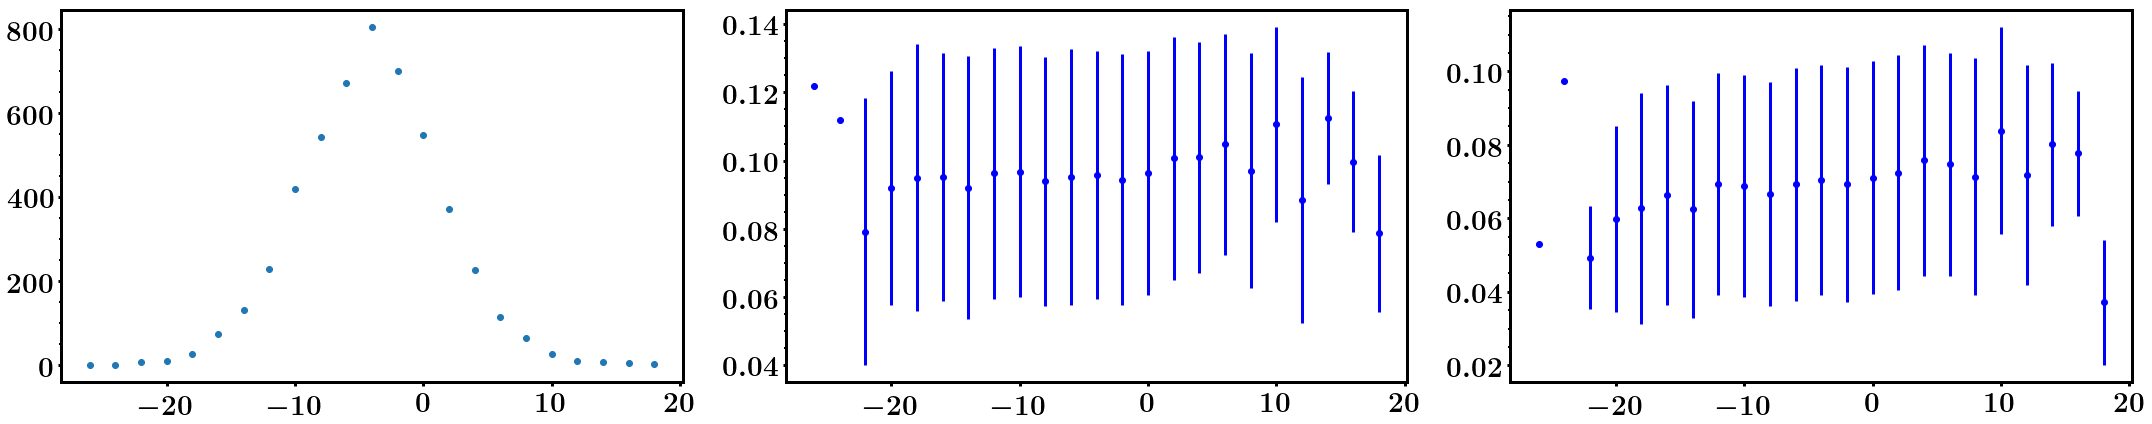

In [35]:
vec = [-1, -1, 1, 1]    
irreg_indices = [irregularity_index(motif, vec) for motif in motives]

ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

indices = irreg_indices
c_max_dict = complexity_dict(indices, max_complexities)
c_mean_dict = complexity_dict(indices, mean_complexities)
values, count = np.unique(indices, return_counts=True)

ax = axes[0]
ax.plot(values, count, 'o')
for ax, c_dict in [[axes[1], c_max_dict], [axes[2], c_mean_dict]]:
    for k, v in sorted(c_dict.items(), key=lambda x: x[0]):
        ax.errorbar(k, np.mean(v), np.std(v), marker='o', color='blue')

plt.tight_layout()
plt.show()

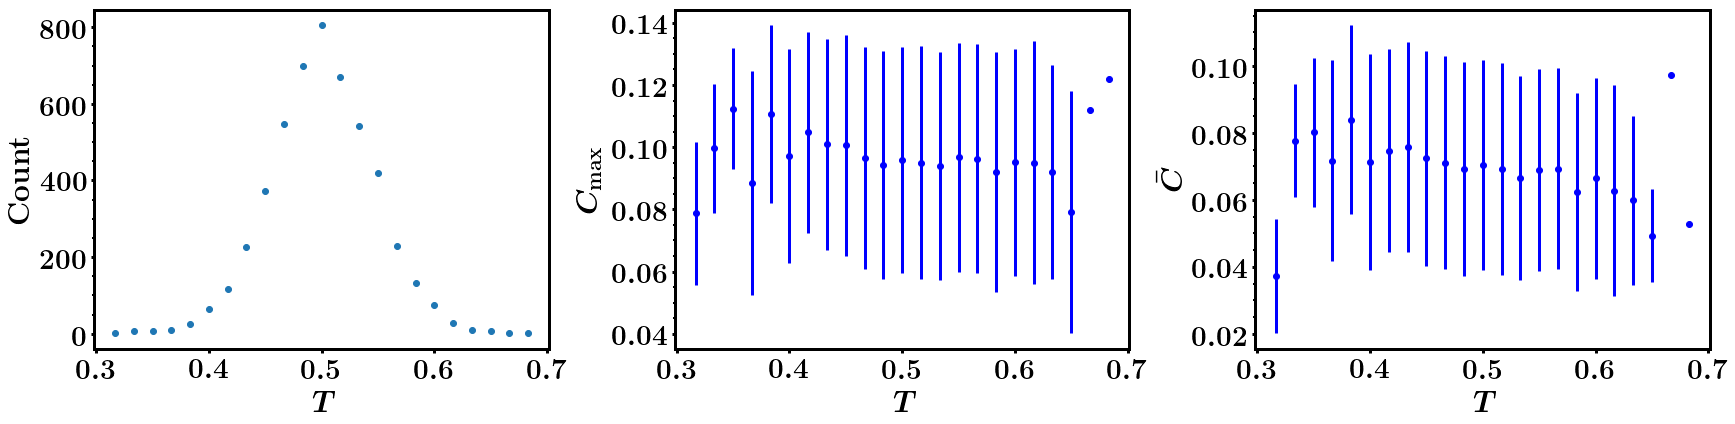

In [81]:
ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

indices = tr_indices
c_max_dict = complexity_dict(indices, max_complexities)
c_mean_dict = complexity_dict(indices, mean_complexities)
values, count = np.unique(indices, return_counts=True)

ax = axes[0]
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$\mathrm{Count}$')
ax.plot(values, count, 'o')
for ax, c_dict in [[axes[1], c_max_dict], [axes[2], c_mean_dict]]:
    for k, v in sorted(c_dict.items(), key=lambda x: x[0]):
        ax.set_xlabel(r'$T$')
        ax.errorbar(k, np.mean(v), np.std(v), marker='o', color='blue')
        
axes[1].set_ylabel(r'$C_{\mathrm{max}}$')
axes[2].set_ylabel(r'$\bar{C}$')

plt.tight_layout()
plt.savefig(fig_dir + '/C_vs_T.png')
plt.show()

/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


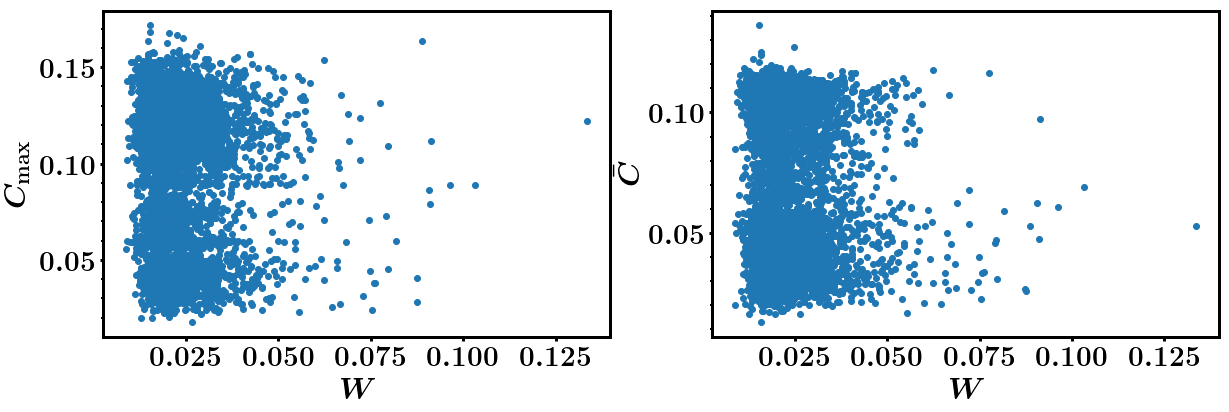

In [79]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xlabel(r'$W$')
ax.set_ylabel(r'$C_{\mathrm{max}}$')
ax.plot(walk_balances, max_complexities, 'o')

ax = axes[1]
ax.set_xlabel(r'$W$')
ax.set_ylabel(r'$\bar{C}$')
ax.plot(walk_balances, mean_complexities, 'o')

#plt.tight_layout()
plt.savefig(fig_dir + '/C_vs_W.png')
plt.show()

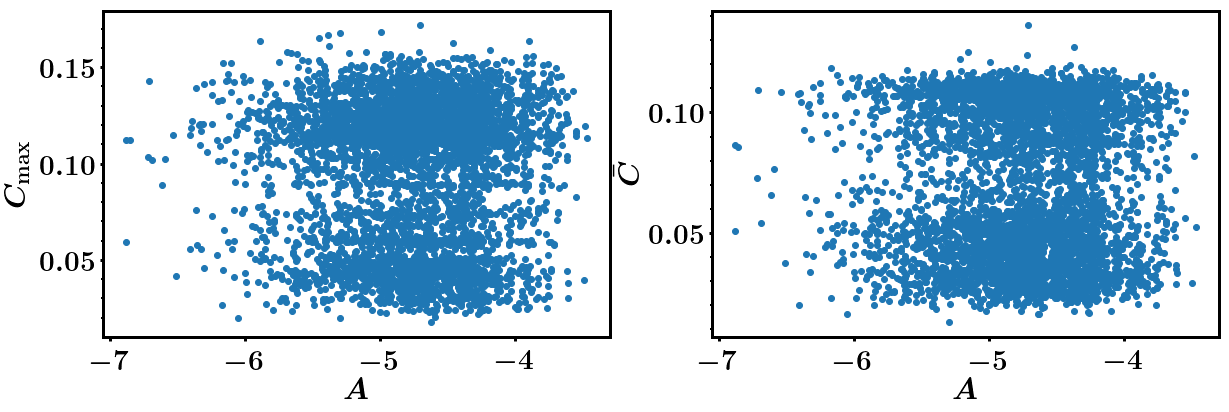

In [80]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xlabel(r'$A$')
ax.set_ylabel(r'$C_{\mathrm{max}}$')
ax.plot(algebraic_conflicts, max_complexities, 'o')

ax = axes[1]
ax.set_xlabel(r'$A$')
ax.set_ylabel(r'$\bar{C}$')
ax.plot(algebraic_conflicts, mean_complexities, 'o')

#plt.tight_layout()
plt.savefig(fig_dir + '/C_vs_A.png')
plt.show()

In [54]:
def readMatrices(data_dir, samples):
    file_names = ['Knewmat_{}.mat'.format(i) for i in range(1, samples+1)]
    matrices = []
    for file_name in file_names:
        full_path = os.path.join(data_dir, file_name)
        if not os.path.isfile(full_path):
            print(full_path)
            break

        matrix = np.sign(loadmat(full_path)['K'])
        matrix = matrix.astype('int')
        if not (matrix.T == matrix).all():
            print('Non symmetric matrix')
            break
        matrices.append(matrix)
    return matrices

def getMotives(A):
    mask = [True, True, False, True, True]
    coop_dict = np.zeros(shape=(10, 10, 10))
    for i in range(10):
        for j in range(i+1, 10):
            for k in range(j+1, 10):
                coop_number = A[i,j] + A[j,k] + A[k,i]
                coop_dict[i,j,k] = coop_number
    motives_count = np.unique(coop_dict, return_counts=True)[1]
    return motives_count[mask]

def irregularity_index(motif, vec):
    index = np.dot(vec, motif)
    return index
        
def walkBasedBalance(A):
    """ Eq (4.5) """
    eigvals = sp.linalg.eigvalsh(A)
    abs_eigvals = sp.linalg.eigvalsh(np.abs(A))
    num = np.sum([np.exp(l) for l in eigvals])
    denom = np.sum([np.exp(l) for l in abs_eigvals])
    return  num / denom

def triangleIndex(A):
    """ Eq (4.4) """
    A3 = np.linalg.matrix_power(A, 3)
    abs_A3 = np.linalg.matrix_power(np.abs(A), 3)
    tr_index = 0.5 * (np.trace(A3)/np.trace(abs_A3) + 1)
    return tr_index

def algebraicConflic(A, D):
    L = D - A
    return np.min(sp.linalg.eigvalsh(A))

def getComplexities(data_dir, samples, func='max'):
    
    if func == 'max':
        func = np.max
    
    file_names = ['properties_v{}.txt'.format(i) for i in range(1, samples+1)]
    complexities = []
    for file_name in file_names:
        full_path = os.path.join(data_dir, file_name)
        aux = np.loadtxt(full_path)
        complexity = func(aux[:,2])
        complexities.append(complexity)
    return complexities

def complexity_dict(indices, complexities):
    c_values = {}
    for index, c in zip(indices, complexities):
        if index not in c_values:
            c_values[index] = [c]
        else:
            c_values[index].append(c)
    return c_values   